In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=deaecfc9e18ff52aa88847081837573b218141fe022dc9e2abef7e606c3fba50
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


# Loading the Data
We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# 1. Load and clean data
raw = pd.read_csv("./compas-scores-two-years.csv")

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:



*   If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
*   Coded the recidivist flag -- is_recid -- to be -1 if could not find a compas case at all.


*   In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
*   Filtering the underlying data to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.





In [3]:
# Select relevant columns and apply filters
df = raw.loc[
    (raw.days_b_screening_arrest <= 30) &
    (raw.days_b_screening_arrest >= -30) &
    (raw.is_recid != -1) &
    (raw.c_charge_degree != 'O') &
    (raw.score_text != 'N/A'),
    ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
     'priors_count', 'days_b_screening_arrest', 'decile_score',
     'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']
].copy()

# 2. Basic counts and percentages
total = len(df)
recid_count = df.two_year_recid.sum()
print(f"Total records: {total}")
print(f"Recidivism count: {recid_count}")

Total records: 6172
Recidivism count: 2809


Higher COMPAS scores are slightly correlated with a longer length of stay.

In [4]:
df['length_of_stay'] = pd.to_numeric(pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in']))
# Convert timedelta to days
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])).dt.days
# The .dt.days accessor is used directly on the timedelta result
correlation = df['length_of_stay'].corr(df['decile_score'])
print(f"Correlation between length of stay and decile score: {correlation}")

df["age_cat"].value_counts()

Correlation between length of stay and decile score: 0.20747808478031807


,count
age_cat,
25 - 45,3532
Less than 25,1347
Greater than 45,1293


In [5]:
df["race"].value_counts()

,count
race,
African-American,3175
Caucasian,2103
Hispanic,509
Other,343
Asian,31
Native American,11


Recidivism rate: 45.51%
Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


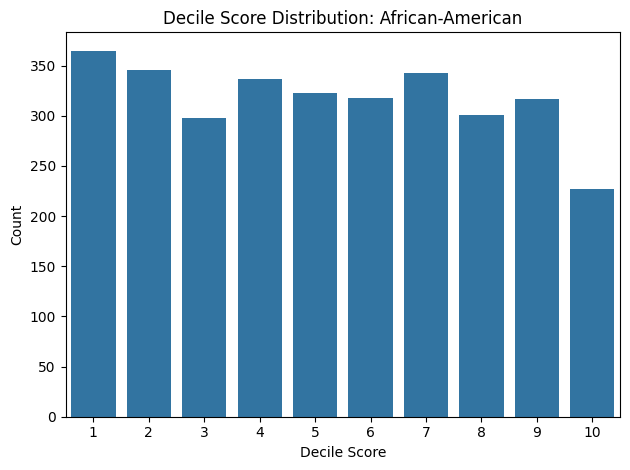

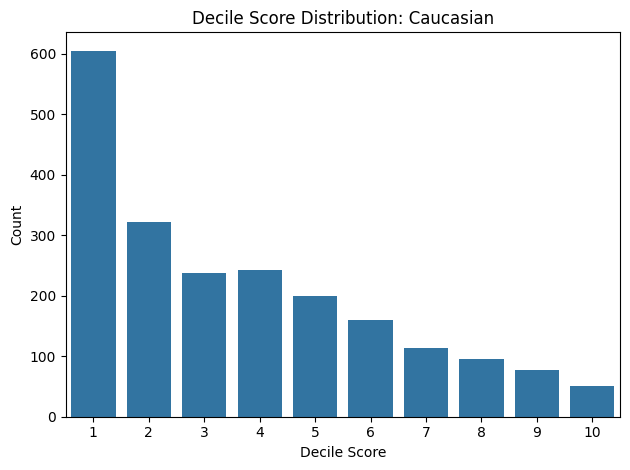

In [6]:
print(f"Recidivism rate: {recid_count/total*100:.2f}%")

print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

# 3. Distribution by decile_score for African-American vs Caucasian
for race_label in ['African-American', 'Caucasian']:
    plt.figure()
    subset = df[df.race == race_label]
    sns.countplot(x='decile_score', data=subset, order=sorted(df.decile_score.unique()))
    plt.title(f"Decile Score Distribution: {race_label}")
    plt.xlabel('Decile Score')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


In [7]:
cross_tab = pd.crosstab(df['decile_score'], df['race'])
cross_tab

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


In [8]:
!pip install --upgrade statsmodels

# Racial Bias in Compas
After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [9]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
# Assuming 'df' is your pandas DataFrame as defined in the previous code

# Convert relevant columns to categorical factors
df['crime_factor'] = pd.Categorical(df['c_charge_degree'])
df['age_factor'] = pd.Categorical(df['age_cat'])
df['age_factor'] = df['age_factor'].cat.reorder_categories(df['age_factor'].cat.categories, ordered=True)  # Ensure correct order
df['age_factor'] = df['age_factor'].cat.set_categories(df['age_factor'].cat.categories, ordered=True)
df['race_factor'] = pd.Categorical(df['race'])
df['race_factor'] = df['race_factor'].cat.reorder_categories(df['race_factor'].cat.categories, ordered=True)
df['gender_factor'] = pd.Categorical(df['sex']).rename_categories({'Male': "Male", 'Female': 'Female'})
df['gender_factor'] = df['gender_factor'].cat.reorder_categories(df['gender_factor'].cat.categories, ordered=True)
df['score_factor'] = pd.Categorical(df['score_text'] != "Low").rename_categories({True: "HighScore", False: "LowScore"})

# Fit the logistic regression model using statsmodels
model = smf.glm(formula='score_factor ~ gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid',
                data=df, family=sm.families.Binomial()).fit() # Change smf.families to sm.families

# Print the model summary
print(model.summary())

                                   Generalized Linear Model Regression Results                                   
Dep. Variable:     ['score_factor[LowScore]', 'score_factor[HighScore]']   No. Observations:                 6172
Model:                                                               GLM   Df Residuals:                     6160
Model Family:                                                   Binomial   Df Model:                           11
Link Function:                                                     Logit   Scale:                          1.0000
Method:                                                             IRLS   Log-Likelihood:                -3084.2
Date:                                                   Sun, 18 May 2025   Deviance:                       6168.4
Time:                                                           19:52:02   Pearson chi2:                 6.07e+03
No. Iterations:                                                        6   Pseudo R-squ.

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [10]:
import math

control = math.exp(-1.52554) / (1 + math.exp(-1.52554))
result = math.exp(0.47721) / (1 - control + (control * math.exp(0.47721)))
result


1.4528408658138932

Women are 19.4% more likely than men to get a higher score.

In [11]:
control = math.exp(-1.52554) / (1 + math.exp(-1.52554))
result = math.exp(0.22127) / (1 - control + (control * math.exp(0.22127)))
result

1.1947978508506671

People under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [12]:
control = math.exp(-1.52554) / (1 + math.exp(-1.52554))
result = math.exp(1.30839) / (1 - control + (control * math.exp(1.30839)))
result


2.4961202077189455

# Risk of Violent Recidivism
Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [13]:
violent = pd.read_csv("./compas-scores-two-years-violent.csv")
violent = violent.loc[
    (violent.days_b_screening_arrest <= 30) &
    (violent.days_b_screening_arrest >= -30) &
    (violent.is_recid != -1) &
    (violent.c_charge_degree != 'O') &
    (violent.score_text != 'N/A')
].copy()

print(len(violent))
print(violent.two_year_recid.sum())

4020
652


In [14]:
violent["age_cat"].value_counts()

,count
age_cat,
25 - 45,2300
Greater than 45,954
Less than 25,766


In [15]:
violent["race"].value_counts()

,count
race,
African-American,1918
Caucasian,1459
Hispanic,355
Other,255
Asian,26
Native American,7


In [16]:
violent["v_score_text"].value_counts()

,count
v_score_text,
Low,2913
Medium,828
High,279


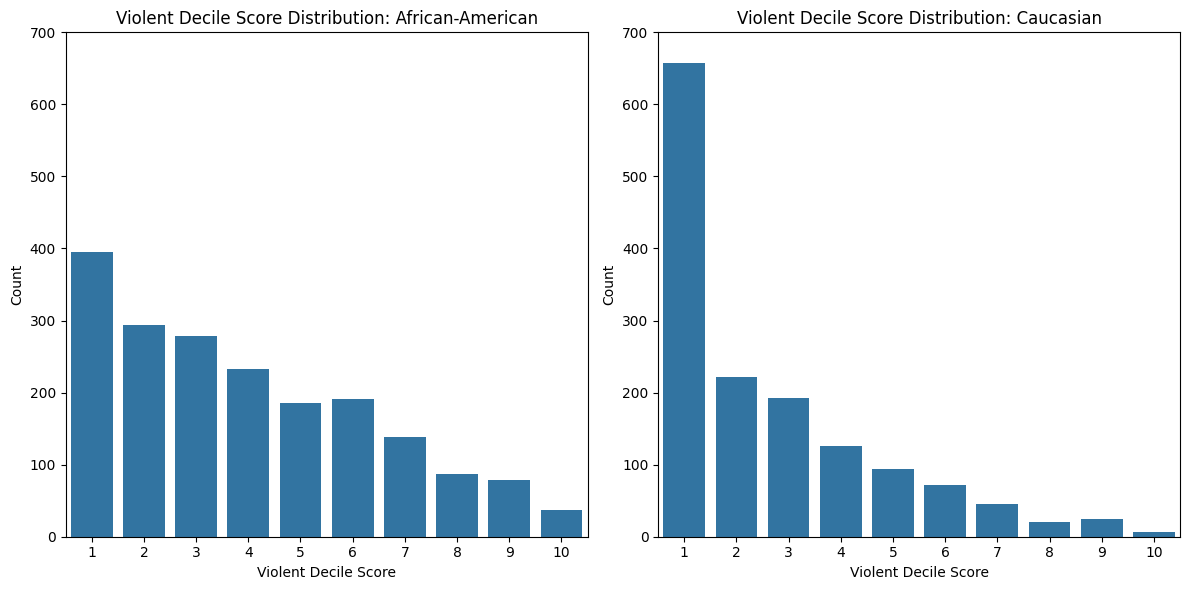

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, race_label in enumerate(['African-American', 'Caucasian']):
    subset = violent[violent.race == race_label]
    sns.countplot(x='v_decile_score', data=subset, order=sorted(violent.v_decile_score.unique()), ax=axes[i])
    axes[i].set_title(f"Violent Decile Score Distribution: {race_label}")
    axes[i].set_xlabel("Violent Decile Score")
    axes[i].set_ylabel("Count")
    axes[i].set_ylim(0, 700)

plt.tight_layout()
plt.show()


In [18]:
df['crime_factor'] = pd.Categorical(df['c_charge_degree'])
df['age_factor'] = pd.Categorical(df['age_cat'])
# Reorder categories to ensure correct order and set them as ordered
df['age_factor'] = df['age_factor'].cat.reorder_categories(df['age_factor'].cat.categories, ordered=True)
df['age_factor'] = df['age_factor'].cat.set_categories(df['age_factor'].cat.categories, ordered=True)

df['race_factor'] = pd.Categorical(df['race'])
race_labels = ["African-American", "Asian", "Caucasian", "Hispanic", "Native American", "Other"]
df['race_factor'] = df['race_factor'].cat.rename_categories(race_labels)
# Set reference level
df['race_factor'] = df['race_factor'].cat.reorder_categories(['Caucasian'] + [r for r in race_labels if r != 'Caucasian'], ordered=True)


df['gender_factor'] = pd.Categorical(df['sex']).rename_categories({'Male': "Male", 'Female': 'Female'})
df['gender_factor'] = df['gender_factor'].cat.reorder_categories(['Male', 'Female'], ordered=True)

df['score_factor'] = pd.Categorical(df['score_text'] != "Low").rename_categories({True: "HighScore", False: "LowScore"})
# Fit the logistic regression model using statsmodels
model = smf.glm(formula='score_factor ~ gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid',
                data=df, family=sm.families.Binomial()).fit()

# Print the model summary
print(model.summary())


                                   Generalized Linear Model Regression Results                                   
Dep. Variable:     ['score_factor[LowScore]', 'score_factor[HighScore]']   No. Observations:                 6172
Model:                                                               GLM   Df Residuals:                     6160
Model Family:                                                   Binomial   Df Model:                           11
Link Function:                                                     Logit   Scale:                          1.0000
Method:                                                             IRLS   Log-Likelihood:                -3084.2
Date:                                                   Sun, 18 May 2025   Deviance:                       6168.4
Time:                                                           19:52:04   Pearson chi2:                 6.07e+03
No. Iterations:                                                        6   Pseudo R-squ.

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

In [19]:
control = math.exp(-2.24274) / (1 + math.exp(-2.24274))
result = math.exp(0.65893) / (1 - control + (control * math.exp(0.65893)))
result

1.7739209589164604

Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [20]:
control = math.exp(-2.24274) / (1 + math.exp(-2.24274))
result = math.exp(3.14591) / (1 - control + (control * math.exp(3.14591)))
result

7.414239863565466

# Directions of the Racial Bias

In [22]:
import csv
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable

# 1. Read and validate all Person records
people = []
with open("./cox-parsed.csv", newline='') as f:
    reader = PeekyReader(csv.DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

# 2. Build the “population”:
#    include everyone with a valid score
#    AND (either a recidivist discharged ≤ 730 days OR lifetime > 730 days)
population = [
    person for person in people
    if person.score_valid
    and (
        (person.recidivist and person.lifetime <= 730)
        or person.lifetime > 730
    )
]

# 3. Extract the recidivists subset:
#    recidivists whose discharge was within 730 days
recidivists = [
    person for person in population
    if person.recidivist and person.lifetime <= 730
]

# 4. Everyone else in “population” (i.e., survivors)
recid_set = set(recidivists)
survivors = [
    person for person in population
    if person not in recid_set
]

# 5. (Optional) Inspect your counts
print(f"Total valid people:   {len(people)}")
print(f"Filtered population:  {len(population)}")
print(f"Recidivists (≤730d):  {len(recidivists)}")
print(f"Survivors (>730d):     {len(survivors)}")

Total valid people:   7225
Filtered population:  7214
Recidivists (≤730d):  3251
Survivors (>730d):     3963


In [23]:
print("All defendants")
table(list(recidivists), list(survivors))

All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [24]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, population)),
                                                statistics.stdev(map(lambda i: i.lifetime, population))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, population))))

Average followup time 622.87 (sd 392.19)
Median followup time 766


Overall, the false positive rate is 32.35%.

In [25]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recidivists)), list(filter(is_afam, survivors)))

Black defendants
           	Low	High
Survived   	990	805	0.49
Recidivated	532	1369	0.51
Total: 3696.00
False positive rate: 44.85
False negative rate: 27.99
Specificity: 0.55
Sensitivity: 0.72
Prevalence: 0.51
PPV: 0.63
NPV: 0.65
LR+: 1.61
LR-: 0.51


That number is higher for African Americans at 44.85%.

In [26]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recidivists)), list(filter(is_white, survivors)))

White defendants
           	Low	High
Survived   	1139	349	0.61
Recidivated	461	505	0.39
Total: 2454.00
False positive rate: 23.45
False negative rate: 47.72
Specificity: 0.77
Sensitivity: 0.52
Prevalence: 0.39
PPV: 0.59
NPV: 0.71
LR+: 2.23
LR-: 0.62


And lower for whites at 23.45%.

Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

In [27]:
44.85 / 23.45

1.9125799573560769

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.

In [28]:
47.72 / 27.99

1.7048946052161487

In [29]:
hightable(list(filter(is_white, recidivists)), list(filter(is_white, survivors)))

           	Low	High
Survived   	1407	81	0.61
Recidivated	771	195	0.39
Total: 2454.00
False positive rate: 5.44
False negative rate: 79.81
Specificity: 0.95
Sensitivity: 0.20
Prevalence: 0.39
PPV: 0.71
NPV: 0.65
LR+: 3.71
LR-: 0.84


In [30]:
hightable(list(filter(is_afam, recidivists)), list(filter(is_afam, survivors)))

           	Low	High
Survived   	1511	284	0.49
Recidivated	1160	741	0.51
Total: 3696.00
False positive rate: 15.82
False negative rate: 61.02
Specificity: 0.84
Sensitivity: 0.39
Prevalence: 0.51
PPV: 0.72
NPV: 0.57
LR+: 2.46
LR-: 0.72


# Risk of Violent Recidivism

In [31]:
import csv
from truth_tables import PeekyReader, Person

# 1. Read and validate all Person records from the violent CSV
vpeople = []
with open("./cox-violent-parsed.csv", newline="") as f:
    reader = PeekyReader(csv.DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

# 2. Build the “violent population”:
#    include everyone with a valid violent score
#    AND (either a violent recidivist discharged ≤ 730 days OR lifetime > 730 days)
vpop = [
    person for person in vpeople
    if person.vscore_valid
    and (
        (person.violent_recidivist and person.lifetime <= 730)
        or person.lifetime > 730
    )
]

# 3. Extract the violent recidivists subset:
#    those violent recidivists whose discharge was within 730 days
vrecid = [
    person for person in vpop
    if person.violent_recidivist and person.lifetime <= 730
]

# 4. Everyone else in “violent population” (i.e., violent survivors)
vrecid_set = set(vrecid)
vsurv = [
    person for person in vpop
    if person not in vrecid_set
]

# 5. (Optional) Inspect your counts
print(f"Total valid violent people:      {len(vpeople)}")
print(f"Filtered violent population:     {len(vpop)}")
print(f"Violent recidivists (≤730d):      {len(vrecid)}")
print(f"Violent survivors (>730d):        {len(vsurv)}")


Total valid violent people:      7201
Filtered violent population:     3435
Violent recidivists (≤730d):      807
Violent survivors (>730d):        2628


In [32]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

All defendants
           	Low	High
Survived   	2040	588	0.77
Recidivated	313	494	0.23
Total: 3435.00
False positive rate: 22.37
False negative rate: 38.79
Specificity: 0.78
Sensitivity: 0.61
Prevalence: 0.23
PPV: 0.46
NPV: 0.87
LR+: 2.74
LR-: 0.50


In [33]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

Black defendants
           	Low	High
Survived   	813	373	0.70
Recidivated	148	356	0.30
Total: 1690.00
False positive rate: 31.45
False negative rate: 29.37
Specificity: 0.69
Sensitivity: 0.71
Prevalence: 0.30
PPV: 0.49
NPV: 0.85
LR+: 2.25
LR-: 0.43


In [34]:
print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

White defendants
           	Low	High
Survived   	837	135	0.82
Recidivated	122	90	0.18
Total: 1184.00
False positive rate: 13.89
False negative rate: 57.55
Specificity: 0.86
Sensitivity: 0.42
Prevalence: 0.18
PPV: 0.40
NPV: 0.87
LR+: 3.06
LR-: 0.67


Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [35]:
31.45 / 13.89

2.2642188624910005

White defendants are 95% more likely to get a lower score and commit another crime than Black defendants.

In [36]:
57.55 / 29.37


1.9594824651004425